# House Prices : Advances Regression Techniques

<br>

### Problématique du Challenge

Ce projet est une compétition de data science, qui consiste à prédire le prix de vente de maisons résidentielles à partir d'un ensemble de 79 variables décrivant chaque aspect des maisons à Ames, Iowa. 

Le but de la compétition est de prédire le prix de vente de chaque maison à partir de l'ensemble de données fourni. Les prédictions sont évaluées en utilisant la Root Mean Square Error (RMSE) entre le logarithme de la valeur prédite et le logarithme du prix de vente observé. 

Le jeu de données utilisé dans cette compétition, "jeu de données Ames Housing", a été créé par Dean De Cock pour une utilisation dans la Data Science. C'est une alternative élargie au célèbre jeu de données "Boston Housing".

Les données d'apprentissage sont disponibles dans le fichier "train.csv", les données à prédire sont disponibles quant à elle dans le fichier "test.csv"

Le challenge Kaggle est disponible au lien suivant :
[House Prices - Advanced Regression Techniques | Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)

<br>

### Notre approche 

Afin de prédire au mieux le prix des maisons de notre base de données test, voici l'approche que nous allons suivre tout au long de ce notebook :
- Préparation de la base de données : Séparation des données train, validation et test
- Choix et analyse des variables explicatives de notre modèle
- Modèle simple benchmark : Utilisation d'une régression linéaire pénalisée qui nous servira de benchmark pour comparer nos modèles de Machine Learning
- Modèle non supervisé : Utilisation d'un ... pour
- Modèle supervisé : Utilisation d'un ... 
- Interprétation de notre modèle à l'aide de ...
- Modèle de Deep Learning : Utilisation d'un ...
- Comparaison des modèles et interprétation des résultats

<br>

### Importation des librairies

In [259]:
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

### Chargement des données

In [260]:
train_set = pd.read_csv("./train.csv")
test_set = pd.read_csv("./test.csv")

print(f"Notre base de donnes est composée de {train_set.shape[0]} obsevations et {train_set.shape[1]} colonnes")

Notre base de donnes est composée de 1460 obsevations et 81 colonnes


Regardons les premières observations de notre data

In [261]:
train_set.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [262]:
test_set.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Nous remarquons que la colonne "Id" est inutile dans nos données d'entraînement, nous pouvons donc la retirer de notre étude. Pour les donnée de test, nous allons remplacer l'index de notre dataframe par cette colonne *Id*.

De plus, séparons notre variable d'étude **SalePrice** de nos variables explicatives. Nous nous retrouvons alors avec 79 variables explicatives.

In [263]:
train_set.drop("Id", axis=1, inplace = True)
test_set.set_index('Id', inplace=True)

y_label = "SalePrice"
y_train = train_set[y_label]
X_train = train_set.drop(y_label, axis=1)

X_test = test_set

Enfin, divison notre échantillon d'entraînement en un train set et un validation set à l'aide de la fonction suivante :

In [264]:
def split_data(X, y, ratio):
    n = X.shape[0]
    train_index = np.random.choice(n, int(n * ratio), replace=False)
    validation_index = np.delete(np.arange(n), train_index)
    return X.iloc[train_index], y.loc[train_index], X.loc[validation_index], y.loc[validation_index]

In [265]:
X_train, y_train, X_validation, y_validation = split_data(X_train, y_train, 0.7)

Pour avoir une idée de la variable que nous cherchons à prédire, voici un histogramme du prix des maisons de notre training set

count      1021.000000
mean     180975.716944
std       82257.849794
min       34900.000000
25%      129000.000000
50%      161750.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64


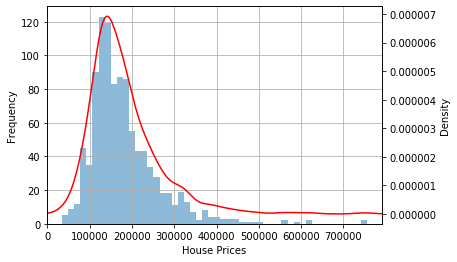

In [266]:
print(y_train.describe())
ax = y_train.hist(bins=50, alpha=0.5)
ax.set_ylabel('Frequency')
ax.set_xlabel("House Prices")
ax.set_xlim(0)
# Ajouter la courbe de densité sur un axe y secondaire
y_train.plot.density(ax=ax.twinx(), color='red')
plt.show()

Nous allons maintenant étudier les variables explicatives et sélectionner celles qui nous semblent pertinentes afin d'obtenir les meilleures prédictions. 

Commençons par avoir une vue d'ensemble sur ces variables

In [267]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1021 entries, 892 to 604
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1021 non-null   int64  
 1   MSZoning       1021 non-null   object 
 2   LotFrontage    850 non-null    float64
 3   LotArea        1021 non-null   int64  
 4   Street         1021 non-null   object 
 5   Alley          60 non-null     object 
 6   LotShape       1021 non-null   object 
 7   LandContour    1021 non-null   object 
 8   Utilities      1021 non-null   object 
 9   LotConfig      1021 non-null   object 
 10  LandSlope      1021 non-null   object 
 11  Neighborhood   1021 non-null   object 
 12  Condition1     1021 non-null   object 
 13  Condition2     1021 non-null   object 
 14  BldgType       1021 non-null   object 
 15  HouseStyle     1021 non-null   object 
 16  OverallQual    1021 non-null   int64  
 17  OverallCond    1021 non-null   int64  
 18  YearBui

Vous pouvez obtenir plus d'informations sur chacune des variables explicatives dans le document *data_description.txt*
<br>

On remarque aisément dans l'output ci-dessus que nous disposons de variables numériques et catégorielles. Dans une précédente version du notebook que vous pouvez retrouver sur GitHub, nous considérions uniquement les variables numériques. Nous allons maintenant aussi considérer les variables catégorielles afin d'améliorer le pouvoir prédictif de nos modèles

Pour ce faire, nous allons dans un premier temps retirer les features avec un nombre trop important de valeurs manquantes. En analysant nos données, nous décidons que 10% de valeurs manquantes dans une colonne est un seuil non négligeable et donc que nous retirons ce feature de notre étude (c'est à dire de nos trois sets).

In [268]:
# Enlever les features avec plus de 10% de valeurs manquantes
missing_values_by_column = X_test.isnull().sum()
for column, missing_values in missing_values_by_column.items():
    if missing_values != 0:
        if missing_values / len(X_test) > 0.1:
            X_train.drop(column, axis=1, inplace=True)
            X_validation.drop(column, axis=1, inplace=True)
            X_test.drop(column, axis=1, inplace=True)

Maintenant que nos sets sont cleanés des features avec trop de valeurs manquantes, nous devons remplir les valeurs nulles de nos dataframes afin d'éviter toute erreur. 

Pour les variables catégorielles, nous décidons de remplacer les valeurs nulles par le mode de chaque feature.
Pour les variables numériques, nous décidons de remplacer les valeurs nulles par la médiane de chaque feature.

In [269]:
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
numerical_cols = [col for col in X_train.columns if X_train[col].dtype == 'int64' or X_train[col].dtype == 'float']

# Remplacer les valeurs manquantes des features catégorielles par le mode
for col in categorical_cols:
    mode = X_train[col].mode()[0]
    X_train[col].fillna(mode, inplace=True)
    X_validation[col].fillna(mode, inplace=True)
    X_test[col].fillna(mode, inplace=True)

# Remplacer les valeurs manquantes des features numériques par la médiane
for col in numerical_cols:
    median = X_train[col].median()
    X_train[col].fillna(median, inplace=True)
    X_validation[col].fillna(median, inplace=True)
    X_test[col].fillna(median, inplace=True)

Enfin, dans un problème de régression, il n'est pas possible d'utiliser comme telles les variables catégorielles. Nous devons donc faire appel à un encodage pour les incorporer à nos modèles.

Il existe différents types d'encodage, mais celui que nous retenons ici est l'encodage One Hot. En fait, cela va transformer chacune des catégories de nos features en une nouvelle colonne, qui prendra des valeurs de 0 ou 1 pour chaque observation. Ainsi, nous nous retrouvons avec des variables numériques qu'il est alors possible d'utiliser dans nos modèles.

Pour réaliser cet encodage, nous faisons appel à la classe *OneHotEncoder* de **Sickit-Learn**. Pour éviter tout biais, nous entraînons l'encoder sur nos données d'entraînement et l'utilisons sur tel quel sur l'ensemble de nos sets.
Dans le cas où de nouvelles catégories seraient alors présentes dans les données validation ou test, nous faisons le choix de ne pas les considérer dans notre encodage pour éviter toute erreur (même si cela peut générer une légère perte d'information). Cela est possible grâce au paramètre *handle_unknown='ignore'*.

In [270]:
# Création d'un encodeur One-Hot
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(X_train[categorical_cols])

encoded_train_features = pd.DataFrame(encoder.transform(X_train[categorical_cols]), columns=encoder.get_feature_names(categorical_cols), index=X_train.index)
encoded_validation_features = pd.DataFrame(encoder.transform(X_validation[categorical_cols]), columns=encoder.get_feature_names(categorical_cols), index=X_validation.index)
encoded_test_features = pd.DataFrame(encoder.transform(X_test[categorical_cols]), columns=encoder.get_feature_names(categorical_cols), index=X_test.index)

# Ajout des variables catégorielles encodées au dataframe en supprimant les colonnes initiales
X_train = pd.concat([X_train.drop(categorical_cols, axis=1), encoded_train_features], axis=1)
X_validation = pd.concat([X_validation.drop(categorical_cols, axis=1), encoded_validation_features], axis=1)
X_test = pd.concat([X_test.drop(categorical_cols, axis=1), encoded_test_features], axis=1)

Ainsi, nous obtenons trois nouveaux sets avec de nombreux features. Par exemple, voilà à quoi ressemble les premières observartions de notre train set.

In [271]:
X_train.head(10)

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
892,20,8414,6,8,1963,2003,0.0,663,0,396,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1105,60,12256,8,5,1994,1995,362.0,1032,0,431,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
413,30,8960,5,6,1927,1950,0.0,0,0,1008,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
522,50,5000,6,7,1947,1950,0.0,399,0,605,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1036,20,12898,9,5,2007,2008,70.0,1022,0,598,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
614,180,1491,4,6,1972,1972,0.0,150,480,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
218,50,15660,7,9,1939,2006,312.0,341,0,457,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1160,160,2280,6,5,1978,1978,0.0,311,0,544,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
649,180,1936,4,6,1970,1970,0.0,131,499,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
887,50,16466,5,7,1955,1955,0.0,0,0,816,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Etudions alors ces variables un peu plus en détail. Pour cela, commençons par une vue globale de nos variables numériques.

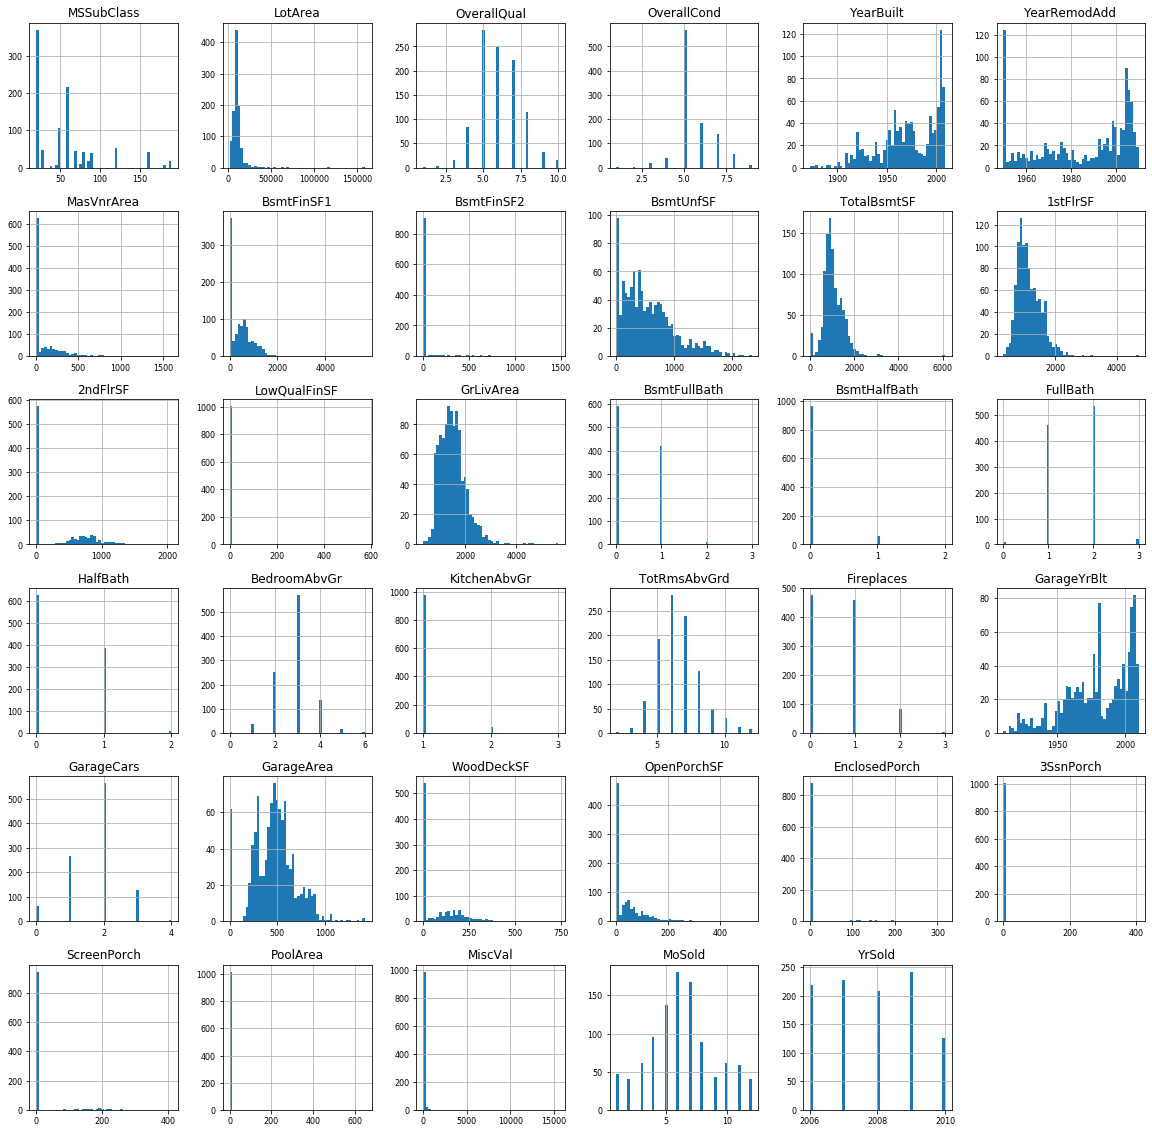

In [272]:
X_train[numerical_cols].hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

Statistiques descriptives !!!

Maintenant que nous avons sélectionné nos variables explicatives, il nous semble pertinent de standardiser chacune de ces variables afin d'éviter le poids disproportionné de certaines variables aux valeurs extrêmes. En réalité, cette normalisation n'est utile que pour les variables numériques mais grâce à l'encodage One Hot des variables catégorielles avec des 0 et 1, cela ne pose pas de problème lors de la normalisation.

In [273]:
min_train = X_train.min(axis=0)
max_train = X_train.max(axis=0)

X_train_norm = (X_train - min_train) / (max_train - min_train)
X_validation_norm = (X_validation - min_train) / (max_train - min_train)
X_test_norm = (X_test - min_train) / (max_train - min_train)

Nos données sont alors prêtes à être utilisées dans différents modèles.

### Modèle de référence : Régression linéaire

Dans le cadre de notre problème, nous utiliserons une régression linéaire par Moindres Carrés Ordinaires comme benchmark afin de comparer nos modèles de Machine Learning par la suite. Pour cela, nous utilisons le package *LinearRegression* de **Sickit-Learn**

In [222]:
linear_reg = LinearRegression()
linear_reg.fit(X_train_norm, y_train)

LinearRegression()

Comme expliqué dans l'introduction de ce notebook, notre métrique d'évalutation est la RMSE sur le logarithme des valeurs prédites et le logarithme des valeurs observés

In [223]:
def compute_score(y_pred, y_obs):
    return np.sqrt(np.mean((np.log(y_pred) - np.log(y_obs)) ** 2))

In [224]:
y_train_pred = linear_reg.predict(X_train_norm)
rmse_train = compute_score(y_train_pred, y_train)
print(f"La métrique calculée sur notre échantillon train avec la régression linéaire est : {round(rmse_train, 5)}")
y_validation_pred = linear_reg.predict(X_validation_norm)
rmse_validation = compute_score(y_validation_pred, y_validation)
print(f"La métrique calculée sur notre échantillon validation avec la régression linéaire est : {round(rmse_validation, 5)}")

La métrique calculée sur notre échantillon train avec la régression linéaire est : 0.11238
La métrique calculée sur notre échantillon validation avec la régression linéaire est : 1.49687


Pour calculer cette métique sur notre échantillon test, nous devons exporter un fichier csv dans le format demandé par le challenge Kaggle

In [225]:
def export_predictions(X, y_pred, file_name):
    df_output = pd.DataFrame({"Id": X.index, "SalePrice": y_pred})
    df_output.to_csv(file_name, index=False)

In [228]:
y_test_pred = linear_reg.predict(X_test_norm)
export_predictions(X_test_norm, y_test_pred, "predictions_ref.csv")
print(f"La métrique calculée sur notre échantillon test avec la régression linéaire est : 2.05030")

La métrique calculée sur notre échantillon test avec la régression linéaire est : 2.05030


### Modèle non supervisé : K-means

Dans le cadre d'un problème de régression, il n'est pas directement possible d'utiliser un modèle non supervisé pour prévoir la sortie. En effet, un modèle non supervisé se base sur des features sans connaître les labels, et donc ne peut que clusteriser les données pour regrouper les observations similaires.

Dans notre étude, nous allons donc utiliser l'algorithme K-means afin de clusturiser nos données, et ainsi ajouter une variable explicative à notre régression linéaire effectuée précédemment. Ainsi, nous verrons si regrouper les maisons similaires à un impact positif sur la capacité de notre modèle à prédire le prix des maisons

<br>

Nous voulons tout d'abord déterminer le nombre de clusters optimal afin de classifier nos données d'entraînement. Pour cela, nous allons regarder d'une part l'inertie et d'autre part la silhouette en faisant varier le nombre de clusters. Ainsi, nous pourrons obtenir une idée du nombre de clusters le plus pertinent pour classifier nos données.

In [229]:
kmeans_per_k = [KMeans(n_clusters=k, init="random", n_init=10, algorithm="full", random_state=42).fit(X_train_norm) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

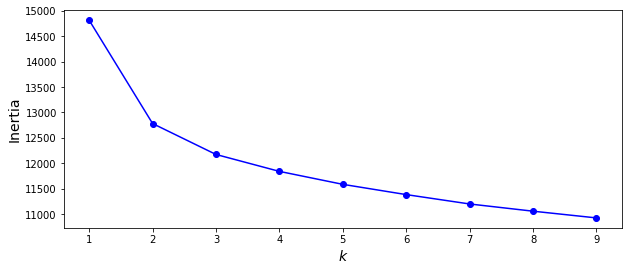

In [230]:
plt.figure(figsize=(10, 4))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [231]:
silhouette_scores = [silhouette_score(X_train_norm, model.labels_)
                     for model in kmeans_per_k[1:]]

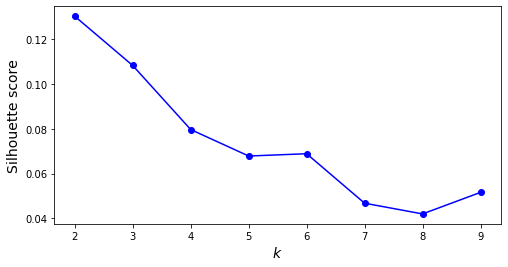

In [232]:
plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

L'analyse des deux métriques précédentes nous donne une valeur optimale potentielle pour le nombre de clusters : 2. 

Nous allons donc appliquer l'algorithme K-means avec ce nombre de clusters, ajouter ce feature à nos données et comparer ce nouveau modèle avec celui de référence.

<br>

Pour ce faire, nous initialisons notre algorithme K-means et clusterisons nos données. L'information du cluster de chaque maison est ajoutée dans chacun des dataframes, en appliquant une standardisation min max (le min étant égal à 0 et le max à k-1).

Nous pouvons alors appliquer de nouveau une régression linéaire sur nos données d'entraînement et comparer le score de nos prédictions

In [242]:
for k_optimal in [2]:
    kmeans = KMeans(n_clusters=k_optimal, init="random", n_init=10,
                                algorithm="full", random_state=42)
    kmeans.fit(X_train_norm)

    labels_train = kmeans.predict(X_train_norm)
    labels_validation = kmeans.predict(X_validation_norm)
    labels_test = kmeans.predict(X_test_norm)

    X_train_norm["Label"] = labels_train.astype(float) / (k_optimal - 1)
    X_validation_norm["Label"] = labels_validation.astype(float) / (k_optimal - 1)
    X_test_norm["Label"] = labels_test.astype(float) / (k_optimal - 1)

    linear_reg = LinearRegression()
    linear_reg.fit(X_train_norm, y_train)

    y_train_pred = linear_reg.predict(X_train_norm)
    rmse_train = compute_score(y_train_pred, y_train)
    print(f"La métrique calculée sur notre échantillon train avec {k_optimal} clusters est : {round(rmse_train, 5)}")
    y_validation_pred = linear_reg.predict(X_validation_norm)
    rmse_validation = compute_score(y_validation_pred, y_validation)
    print(f"La métrique calculée sur notre échantillon validation avec {k_optimal} clusters est : {round(rmse_validation, 5)}\n")

    y_test_pred = linear_reg.predict(X_test_norm)
    export_predictions(X_test_norm, y_test_pred, f"predictions_kmeans_{k_optimal}.csv")

    X_train_norm.drop("Label", axis=1, inplace=True)
    X_validation_norm.drop("Label", axis=1, inplace=True)
    X_test_norm.drop("Label", axis=1, inplace=True)

La métrique calculée sur notre échantillon train avec 2 clusters est : 0.1122
La métrique calculée sur notre échantillon validation avec 2 clusters est : 2.15015



En soumettant nos prédictions pour les données test sur Kaggle, nous obtenons les résultats suivants :

In [237]:
print(f"La métrique calculée sur notre échantillon test avec 2 clusters est : 2.10523\n")

La métrique calculée sur notre échantillon test avec 2 clusters est : 2.10523



Comme on pouvait s'en douter, l'utilisation d'un modèle non supervisé dans le cadre de notre problème de régression n'apporte pas de pouvoir prédictif. De plus, il paraît logique qu'un nouveau feature classifiant les données dans 2 catégories n'apporte pas de pouvoir prédictif en considérant déjà l'ensemble des features utilisés. Mais même en testant avec des nombres de clusters plus élevés, les résultats ne sont pas satisfaisants.

Nous allons donc maintenant pouvoir nous intéresser à l'implémentation d'un modèle supervisé qui devrait nous donner de meilleures prédictions.

### Modèle supervisé : Random Forest

Dans le cadre de notre problème de prédiction du prix des maisons, nous allons utiliser comme modèle supervisé le Random Forest. Cet algortihme va nous permettre, contrairement au modèle non supervisé, de prédire directement le prix des maisons. 

Pour obtenir les meilleurs résultats à l'aide de notre Random Forest, nous devons tout d'abord déterminer les hyperparamètres optimaux pour notre modèle, que nous pourrons affiner par la suite si nécessaire. 

Pour cela, nous utilisons *GridSearchCV* de **Sickit-Learn** qui permet de sélectionner les hyperparamètres optimaux par validation croisée. 

In [192]:
# Espace de recherche des hyperparamètres
param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)

# Recherche par validation croisée des meilleurs hyperparamètres
grid_search = GridSearchCV(estimator=random_forest_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_norm, y_train)

print("Meilleurs hyperparamètres : ", grid_search.best_params_)
print("Score moyen de validation croisée : ", grid_search.best_score_)

Meilleurs hyperparamètres :  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Score moyen de validation croisée :  -1167332140.450155


Maintenant que nous avons déterminer des valeurs d'yperparamètres pertinentes, nous pouvons appliquer l'algorithme de Random Forest à nos différents sets de données et comparer les résultats avec nos précédents modèles

In [193]:
random_forest_reg = RandomForestRegressor(n_estimators=500, max_depth=20, min_samples_leaf=1, min_samples_split=10, random_state=42)
random_forest_reg.fit(X_train_norm, y_train)

RandomForestRegressor(max_depth=20, min_samples_split=10, n_estimators=500,
                      random_state=42)

In [194]:
y_train_pred = random_forest_reg.predict(X_train_norm)
rmse_train = compute_score(y_train_pred, y_train)
print(f"La métrique calculée sur notre échantillon train avec l'algorithme Random Forest est : {round(rmse_train, 5)}")
y_validation_pred = random_forest_reg.predict(X_validation_norm)
rmse_validation = compute_score(y_validation_pred, y_validation)
print(f"La métrique calculée sur notre échantillon validation avec l'algorithme Random Forest est : {round(rmse_validation, 5)}")

La métrique calculée sur notre échantillon train avec l'algorithme Random Forest est : 0.08438
La métrique calculée sur notre échantillon validation avec l'algorithme Random Forest est : 0.12814


In [204]:
y_test_pred = random_forest_reg.predict(X_test_norm)
export_predictions(X_test_norm, y_test_pred, "predictions_rf.csv")
print(f"La métrique calculée sur notre échantillon test avec l'algorithme Random Forest est : 0.15020")

La métrique calculée sur notre échantillon test avec l'algorithme Random Forest est : 0.15020


On remarque une réelle surperformance de l'algorithme Random Forest comparé à notre modèle de référence que ce soit sur le validation ou le test set.

### Modèle supervisé : Gradient Boosting

Afin de comparer les résultats obtenus avec le Random Forest, nous implémentons un autre modèle supervisé : le Gradient Boosting.

Le fonctionnement d'un modèle de boosting est un apprentissage pas à pas, en corrigeant à chaque nouveau modèle les erreurs des précédents.

Comme pour les modèles précédents, il nous faut déterminer les hyperparamètres optimaux de cet algorithme. Pour cela nous allons boucler sur différentes valeurs de learning rate et de profondeur maximale, et pourrons déterminer ces paramètres ainsi que le nombre d'arbres optimal à l'aide de la méthode *staged_predict()*.

In [196]:
# Espace de recherche du learning rate
learning_rates = [1, 0.5, 0.1, 0.05, 0.01]
depths = [None, 5, 10, 15, 20]

grad_boost_reg = GradientBoostingRegressor(n_estimators=200, random_state=42)

errors = {}
for learning_rate in learning_rates:
    for depth in depths:
        grad_boost_reg.set_params(learning_rate=learning_rate, max_depth=depth)
        grad_boost_reg.fit(X_train_norm, y_train)

        errors[(learning_rate, depth)] = [compute_score(y_validation, y_pred)
                for y_pred in grad_boost_reg.staged_predict(X_validation_norm)] 

In [197]:
min_error_index = min(errors, key=lambda k: min(errors[k]))
errors = errors[min_error_index]

min_error = np.min(errors)
tree_opt = np.argmin(errors) + 1
learning_rate = min_error_index[0]
max_depth = min_error_index[1]

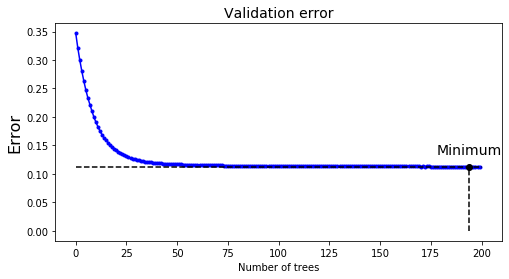

In [199]:
plt.figure(figsize=(8, 4))

plt.plot(errors[0:200], "b.-")
plt.plot([tree_opt, tree_opt], [0, min_error], "k--")
plt.plot([0,200], [min_error, min_error], "k--")
plt.plot(tree_opt, min_error, "ko")
plt.text(tree_opt, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.show()

Dans le cas d'un Gradient Boosting, il est nécessaire de déterminer le nombre d'arbres optimal minimisant notre métrique. En effet, en prenant un nombre d'estimateurs trop grand, on risque de faire de l'overfitting et donc des prédictions moins bonnes sur notre test set.

Maintenant que nous avons déterminé les paramètres optimaux de notre Gradient Boosting, nous allons l'utiliser pour faire des prédictions sur nos différents sets et comparer nos résultats aux précédents modèles. En faisant légèrement varier les hyperparamètres, nous remarquons finalement que la profondeur maximale de 4 donne de meilleurs prédictions sur les train et validation sets mais de moins bons sur le test set, nous allons donc garder notre profondeur maximale à 5.

In [200]:
grad_boost_reg = GradientBoostingRegressor(n_estimators=tree_opt, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
grad_boost_reg.fit(X_train_norm, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=194, random_state=42)

In [201]:
y_train_pred = grad_boost_reg.predict(X_train_norm)
rmse_train = compute_score(y_train_pred, y_train)
print(f"La métrique calculée sur notre échantillon train avec l'algorithme Gradient Boosting est : {round(rmse_train, 5)}")
y_validation_pred = grad_boost_reg.predict(X_validation_norm)
rmse_validation = compute_score(y_validation_pred, y_validation)
print(f"La métrique calculée sur notre échantillon validation avec l'algorithme Gradient Boosting est : {round(rmse_validation, 5)}")

La métrique calculée sur notre échantillon train avec l'algorithme Gradient Boosting est : 0.02431
La métrique calculée sur notre échantillon validation avec l'algorithme Gradient Boosting est : 0.11294


In [203]:
y_test_pred = grad_boost_reg.predict(X_test_norm)
export_predictions(X_test_norm, y_test_pred, "predictions_g_boost.csv")
print(f"La métrique calculée sur notre échantillon test avec l'algorithme Gradient Boosting est : 0.13598")

La métrique calculée sur notre échantillon test avec l'algorithme Gradient Boosting est : 0.13598


Les résultats obtenus sont encore meilleurs qu'avec notre algorithme Random Forest sur l'ensemble de nos sets.